#For colab

# Define custom function

In [ ]:
# mean_reversion 포트폴리오 생성 전략
def mean_reversion2(input_data_arr_raw, industry_list) :

    #=====================
    input_data_arr = np.reshape(input_data_arr_raw, (batch_size, corps))
    encoder_reshaped = np.transpose(np.reshape(industry_list, (-1, corps)))
    corp_classified = np.repeat(-1, corps)

    for ind in range(corps):
        corp_classified[ind] = np.argmax(encoder_reshaped[ind,:])

    industry_list2 = corp_classified.tolist()
    industry_dic = {}
    for industry in industry_list2 :
        industry_dic.update({ industry :np.where(corp_classified == industry, 1, 0)})
    #=======================

    total_ammount = 1

    portfolio = np.zeros(input_data_arr.shape)
    nn_price_s = input_data_arr

    for industry in industry_list2 :
       #print(industry)
        loading_m = industry_dic[industry]
        loading_return = np.where(loading_m == 1, nn_price_s, np.nan)

        for i in range(len(input_data_arr)) :

            loading_return[i] -= np.nanmean(loading_return[i])
            loading_return[i] = np.where(np.isnan(loading_return[i]), 0, loading_return[i])

            portfolio[i] += loading_return[i] 


    portfolio = np.where(np.isnan(portfolio),0 , portfolio)
    portfolio = np.where(portfolio > 0 , -1, 1)

    abs_sum = np.sum(np.abs(portfolio), 1)
    weight = total_ammount/abs_sum 
    weight[total_ammount/abs_sum == np.inf] = 0
    d = np.diag(weight)
    portfolio_w = np.matmul(d, portfolio )
    daily_pnl = np.nansum(np.multiply( portfolio_w[:-1], nn_price_s[1:]),1)
    coeff = np.sqrt(len(daily_pnl))
    returned = coeff*np.nanmean(daily_pnl)/np.nanstd(daily_pnl)
    return returned.astype(np.float32)

In [58]:
import numpy as np
import pandas as pd
import collections
import json
from matplotlib import pyplot as plt

In [ ]:
def make_loading_matrix(industry_list, industry_fg_arr) :
    industry_dic = {}
    for industry in industry_list :
        industry_dic.update({ industry :np.where(industry_fg_arr == industry, 1, 0)})
        #print(industry)
    return industry_dic


In [59]:
#No biased에 대한 결과가 요정도..
def draw_pnl(input_pnl, index_list) :
    draw_data = pd.Series(input_pnl)
    draw_data.index = index_list
    plt.figure(figsize=(10,5))
    plt.plot(draw_data)
    plt.grid(b = True)
    return draw_data


"""
industry_list와 채워진 matrix set을 받으면 loading matrix 로 변환
loading matrix 출력 예시
#loading_m= industry_dic[industry_list[0]]

"""
def make_loading_matrix(industry_list, industry_fg) :
    industry_dic = {}
    for industry in industry_list :
        industry_dic.update({ industry :np.where(industry_fg.values == industry, 1, 0)})
        #print(industry)
    return industry_dic


"""
turn over 계산 function
input
    - portfolio_w : portfolio의 values(numpy type)
    - index_list : 사용하는 데이터의 index list
    
output 
- daliy turnover가 저장된 pd.series type 변수
"""

def make_turn_over_df(portfolio_w , index_list) :
    turn_over = np.zeros(len (portfolio_w))
    for i in range(len (portfolio_w)) :
        if i == len (portfolio_w) -2 :
            break;
        turn_over[i+1] = np.nansum(abs(portfolio_w[i+1] - portfolio_w[i]))

    turn_over_df = pd.Series(turn_over)
    turn_over_df.index = index_list
    return turn_over_df


"""
summary_pnl
 * 포트폴리오의 성과지표를 summary
input
    - portfolio_df : portfolio의 데이터프레임 타입(daily 별 포트폴리오 자산배분이 들어가있음)
    - price_s : 해당기간 주식들의 수익률 정보
    
output 
- summary table : sharp ratio/year pnl/turn over rate 평균등을 계산하고 plot함
"""

def summary_pnl(portfolio_df, turn_over_df, price_s) :
    
    daily_pnl = np.nansum(np.multiply( portfolio_df.values, price_s.values),1)
    #draw_pnl(np.cumsum(daily_pnl), price_s.index)
    cumsum_data = pd.Series(np.cumsum(daily_pnl))
    cumsum_data.index = price_s.index
    plt.figure(figsize=(10,5))
    plt.plot(cumsum_data)
    plt.grid(b = True)
    
    draw_data = pd.Series(daily_pnl)
    draw_data.index = price_s.index

    summary_table = pd.DataFrame(index=draw_data.resample('Y').mean().index , columns=['Sharp_ratio', 'Profit and Loss(%)', 'Turn_over_rate(%)'])
    summary_table['Sharp_ratio'] = draw_data.resample('Y').mean() *np.sqrt(250) / draw_data.resample('Y').std()
    summary_table['Profit and Loss(%)'] = draw_data.resample('Y').mean() *250
    summary_table['Turn_over_rate(%)'] = turn_over_df.resample('Y').mean() *100
    
    return summary_table



In [60]:
# mean_reversion 포트폴리오 생성 전략
def mean_reversion(input_data, industry_list, industry_dic) :
    #input_data = pr_rolling
    total_ammount = 1

    portfolio = np.zeros(input_data.shape)
    nn_price_s = input_data.values

    for industry in industry_list :
        print(industry)
        loading_m = industry_dic[industry]
        loading_return = np.where(loading_m == 1, nn_price_s, np.nan)
        #여기 0값 집어넣어서 난리남..

        for i in range(len(input_data.index)) :

            loading_return[i] -= np.nanmean(loading_return[i])
            loading_return[i] = np.where(np.isnan(loading_return[i]), 0, loading_return[i])

            portfolio[i] += loading_return[i] 


    portfolio = np.where(np.isnan(portfolio),0 , portfolio)
    portfolio = np.where(portfolio > 0 , -1, 1)

    abs_sum = np.sum(np.abs(portfolio), 1)
    weight = total_ammount/abs_sum 
    weight[total_ammount/abs_sum == np.inf] = 0
    d = np.diag(weight)
    portfolio_w = np.matmul(d, portfolio )


    #make portfolio df with init zero
    portfolio_df = input_data.copy()
    for col in portfolio_df.columns:
        portfolio_df[col].values[:] = 0

    portfolio_df.loc[:,:] = portfolio_w
    turn_over_df = make_turn_over_df(portfolio_w , input_data.index)
    
    
    portfolio_df = portfolio_df.shift(1)
    
    return portfolio_df,turn_over_df

In [61]:
def mean_reversion_nc(input_data):
    #input_data = pr_rolling
    total_ammount = 1

    #make portfolio df with init zero
    portfolio_df = input_data.copy()
    for col in portfolio_df.columns:
        portfolio_df[col].values[:] = 0

    #Calc  alpha
    for i,index in enumerate(input_data.index) :

        if i == len(input_data.index)-1 :
            break ;
        day_pr_arr = input_data.values[i]

        alpha =  (day_pr_arr - np.nanmean(day_pr_arr))
        alpha[~np.isnan(day_pr_arr)] = np.where( alpha[~np.isnan(day_pr_arr)] > 0, -1, 1)
        alpha -= np.nanmean(alpha)
        #alpha = -1 * (day_pr_arr -pr_rolling_ar[i] )
        weight_value = total_ammount/ np.sum(np.abs(day_pr_arr[~np.isnan(day_pr_arr)]))   

        alpha[~np.isnan(day_pr_arr)] = weight_value * alpha[~np.isnan(day_pr_arr)]
        portfolio_df.loc[input_data.index[i+1], :] = alpha
        
    turn_over_df = make_turn_over_df(portfolio_df.values , input_data.index)
    return portfolio_df, turn_over_df
    


In [126]:
with open('..//data//daily_price_v.json') as json_file:
    json_data = json.load(json_file)
price_s = pd.read_json(json_data)

with open('..//data//fg_sector_bfff_v.json') as json_file:
    json_data = json.load(json_file)
industry_fg = pd.read_json(json_data)


In [78]:
with open('..//data//daily_price_t.json') as json_file:
    json_data = json.load(json_file)
price_t = pd.read_json(json_data)


In [115]:
portfolio_df.tail(50)

,A005930,A000660,A035420,A005380,A207940,A012330,A068270,A051910,A055550,A005490,...,A900060,A900090,A900130,A900150,A900180,A950010,A950030,A950070,A950100,A950190
2016-05-31,0.000316,-0.000316,-0.000316,-0.000316,0.000316,-0.000316,-0.000316,0.000316,0.000316,0.000316,...,0.000316,0.000316,-0.000316,0.000316,0.000316,0.000316,0.000316,0.000316,0.000316,0.000316
2016-06-01,0.000316,-0.000316,-0.000316,-0.000316,0.000316,-0.000316,-0.000316,0.000316,0.000316,-0.000316,...,0.000316,-0.000316,-0.000316,0.000316,0.000316,0.000316,0.000316,0.000316,0.000316,0.000316
2016-06-02,-0.000316,-0.000316,0.000316,-0.000316,0.000316,-0.000316,0.000316,0.000316,0.000316,0.000316,...,0.000316,-0.000316,-0.000316,0.000316,-0.000316,0.000316,0.000316,0.000316,0.000316,0.000316
2016-06-03,-0.000316,-0.000316,0.000316,-0.000316,0.000316,0.000316,0.000316,0.000316,0.000316,0.000316,...,0.000316,-0.000316,-0.000316,0.000316,-0.000316,0.000316,0.000316,0.000316,0.000316,0.000316
2016-06-07,-0.000316,0.000316,0.000316,-0.000316,0.000316,0.000316,0.000316,0.000316,0.000316,0.000316,...,0.000316,-0.000316,0.000316,0.000316,-0.000316,0.000316,0.000316,0.000316,0.000316,0.000316
2016-06-08,-0.000316,0.000316,0.000316,-0.000316,0.000316,0.000316,0.000316,0.000316,0.000316,-0.000316,...,0.000316,-0.000316,0.000316,0.000316,-0.000316,0.000316,0.000316,0.000316,0.000316,0.000316
2016-06-09,-0.000316,0.000316,0.000316,0.000316,0.000316,0.000316,0.000316,0.000316,-0.000316,-0.000316,...,0.000316,-0.000316,-0.000316,0.000316,-0.000316,0.000316,0.000316,0.000316,0.000316,0.000316
2016-06-10,-0.000316,-0.000316,-0.000316,-0.000316,0.000316,-0.000316,0.000316,0.000316,-0.000316,-0.000316,...,0.000316,-0.000316,-0.000316,0.000316,-0.000316,0.000316,0.000316,0.000316,0.000316,0.000316
2016-06-13,-0.000316,-0.000316,-0.000316,-0.000316,0.000316,-0.000316,0.000316,-0.000316,-0.000316,-0.000316,...,0.000316,0.000316,-0.000316,0.000316,0.000316,0.000316,0.000316,0.000316,0.000316,0.000316
2016-06-14,-0.000316,-0.000316,0.000316,0.000316,0.000316,-0.000316,0.000316,-0.000316,-0.000316,-0.000316,...,0.000316,0.000316,-0.000316,0.000316,0.000316,0.000316,0.000316,0.000316,0.000316,0.000316


In [99]:
price_t.head(20)

,A005930,A000660,A035420,A005380,A207940,A012330,A068270,A051910,A055550,A005490,...,A900060,A900090,A900130,A900150,A900180,A950010,A950030,A950070,A950100,A950190
2016-08-10,-1.66,-3.57,2.65,-1.83,NaN,-0.77,5.04,3.11,-0.73,-0.23,...,NaN,2.45,1.33,NaN,1.86,NaN,NaN,NaN,NaN,NaN
2016-08-11,1.17,2.96,0.39,0.37,NaN,0.78,0.44,-1.51,0.62,-2.27,...,NaN,-0.90,0.60,NaN,-1.83,NaN,NaN,NaN,NaN,NaN
2016-08-12,-0.90,-1.29,0.51,1.12,NaN,0.00,0.00,1.34,0.61,2.55,...,NaN,-0.30,-0.30,NaN,1.24,NaN,NaN,NaN,NaN,NaN
2016-08-16,1.49,-1.89,1.02,-2.21,NaN,-0.77,-0.44,-1.32,-1.22,1.58,...,NaN,1.81,4.42,NaN,6.13,NaN,NaN,NaN,NaN,NaN
2016-08-17,-0.13,-0.45,0.00,1.50,NaN,0.19,1.24,0.38,0.86,-0.67,...,NaN,-0.59,0.48,NaN,-3.18,NaN,NaN,NaN,NaN,NaN
2016-08-18,4.73,1.79,1.39,-1.85,NaN,-1.74,-0.53,-1.33,-0.61,-1.35,...,NaN,-0.90,1.44,NaN,-2.69,NaN,NaN,NaN,NaN,NaN
2016-08-19,2.13,3.66,0.50,0.00,NaN,1.57,0.53,1.16,-1.72,-0.91,...,NaN,0.90,4.72,NaN,2.76,NaN,NaN,NaN,NaN,NaN
2016-08-22,-0.60,1.69,-1.24,-0.38,NaN,-0.19,-2.72,2.48,0.50,0.00,...,NaN,-2.09,-0.45,NaN,-2.69,NaN,NaN,NaN,NaN,NaN
2016-08-23,1.32,-1.11,1.38,0.38,NaN,-2.14,-1.17,0.19,0.12,-0.46,...,NaN,-0.61,-4.98,NaN,-0.92,NaN,NaN,NaN,NaN,NaN
2016-08-24,-2.02,0.42,0.74,2.26,NaN,-0.79,1.37,-0.74,-0.87,3.23,...,NaN,5.83,30.00,NaN,7.43,NaN,NaN,NaN,NaN,NaN


In [14]:
with open('..//data//daily_price.json') as json_file:
    json_data = json.load(json_file)
price_ss = pd.read_json(json_data)
price_ss = price_ss.loc[industry_fg.index, :]
industry_fg = industry_fg.loc[:, price_ss.columns]

#Calc industry loading matrix



# get_indsutry_list

In [121]:
# get_industry_list 

with open('..//data//fg_sector.json') as json_file:
    industry_js = json.load(json_file)
industry_s = pd.read_json(industry_js)

#industry_s전처리 해줘야함..
industry_m = industry_s.copy()
for i in industry_m.columns :
    col = industry_m[i].values
    col = np.where(type(col) == float , 'NaN' , col)
    col = np.where(type(col) == 'nan' , 'NaN' , col)
    col = np.where(col == None , 'NaN'  , col)
    industry_m[i] = col


#한번더 후 처리
hey = industry_m.values
hey[hey == 'nan'] = 'NaN'
industry_m.loc[:,:] = hey

#후처리 한번더..
for i in industry_m.columns :
    col = industry_m[i].values
    col = np.where(type(col) == float , 'NaN' , col)
    col = np.where(type(col) == 'nan' , 'NaN' , col)
    col = np.where(col == None , 'NaN'  , col)
    industry_m[i] = col
    
    #industry_list check
    if i == industry_m.columns[0]:
        c = collections.Counter(industry_m[i])
    c += collections.Counter(industry_m[i])


industry_list = [*c.keys()]


# get_industry dic

In [127]:
industry_dic = make_loading_matrix(industry_list, industry_fg)

In [130]:
len(industry_list)

11

FGSC.25


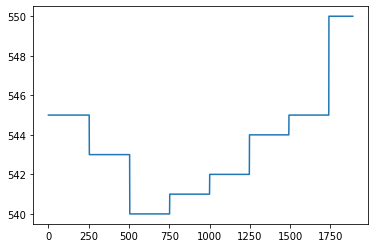

In [128]:
loading_m= industry_dic[industry_list[1]]
sector_1 = np.zeros(len(loading_m))
for i in range(len(loading_m)) :
    sector_1[i] = sum(loading_m[i])
plt.plot(sector_1)
print(industry_list[1])

In [142]:
industry_list[0]

'FGSC.45'

FGSC.45


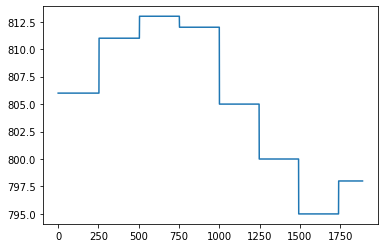

In [143]:
n = 0
loading_m= industry_dic[industry_list[n]]
sector_1 = np.zeros(len(loading_m))
for i in range(len(loading_m)) :
    sector_1[i] = sum(loading_m[i])
plt.plot(sector_1)
print(industry_list[n])

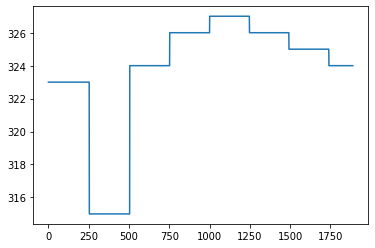

In [310]:
loading_m= industry_dic[industry_list[4]]
sector_1 = np.zeros(len(loading_m))
for i in range(len(loading_m)) :
    sector_1[i] = sum(loading_m[i])
plt.plot(sector_1)

# make portfolio 

In [74]:
price_s.shape

(1890, 3168)

In [40]:
industry_list

['FGSC.45',
 'FGSC.25',
 'NaN',
 'FGSC.35',
 'FGSC.15',
 'FGSC.40',
 'FGSC.30',
 'FGSC.50',
 'FGSC.20',
 'FGSC.10',
 'FGSC.55']

In [ ]:
industry_dic

In [123]:
signal = price_s.rolling(5, min_periods=1).mean()
portfolio_df,turn_over_df = mean_reversion(signal, industry_list, industry_dic)

FGSC.45
FGSC.25
NaN
FGSC.35


C:\Users\cobook\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


FGSC.15
FGSC.40
FGSC.30
FGSC.50
FGSC.20
FGSC.10
FGSC.55


,Sharp_ratio,Profit and Loss(%),Turn_over_rate(%)
2016-12-31,3.522468,7.937095,26.377825
2017-12-31,2.617067,4.597489,26.790539
2018-12-31,2.438846,8.827365,27.357851
2019-12-31,3.608513,10.267453,28.040287


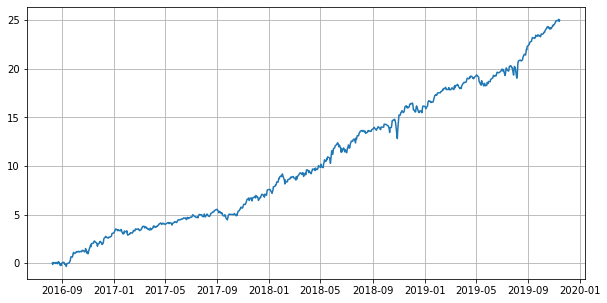

In [124]:
summary_pnl(portfolio_df, turn_over_df, price_s)

In [77]:
price_s.tail()

,A005930,A000660,A035420,A005380,A207940,A012330,A068270,A051910,A055550,A005490,...,A900060,A900090,A900130,A900150,A900180,A950010,A950030,A950070,A950100,A950190
2016-08-03,-2.00,-0.59,-1.12,-1.49,NaN,-2.52,-0.29,-0.60,-2.47,-1.98,...,NaN,-2.07,-6.36,NaN,-0.30,NaN,NaN,NaN,NaN,NaN
2016-08-04,0.00,0.30,0.28,-1.14,NaN,-0.40,1.86,0.60,0.63,-2.24,...,NaN,0.91,-1.94,NaN,0.30,NaN,NaN,NaN,NaN,NaN
2016-08-05,2.90,3.42,2.26,1.92,NaN,2.00,-0.19,-1.79,1.01,1.61,...,NaN,-3.29,0.50,NaN,-0.91,NaN,NaN,NaN,NaN,NaN
2016-08-08,0.51,0.43,3.60,0.00,NaN,0.39,2.60,0.61,2.00,-3.39,...,NaN,0.00,-2.46,NaN,-1.53,NaN,NaN,NaN,NaN,NaN
2016-08-09,-0.13,0.29,0.80,2.63,NaN,1.36,0.56,3.83,-0.12,3.27,...,NaN,1.24,-1.01,NaN,0.00,NaN,NaN,NaN,NaN,NaN


In [72]:
signal = price_s.rolling(5, min_periods=1).mean()
portfolio_df_nc,turn_over_df_nc = mean_reversion_nc(signal)

,Sharp_ratio,Profit and Loss(%),Turn_over_rate(%)
2009-12-31,1.325773,4.409403,38.686288
2010-12-31,-0.311945,-1.053154,47.472726
2011-12-31,1.298668,4.713885,44.562491
2012-12-31,0.408385,1.458432,47.459666
2013-12-31,1.908230,6.030775,57.298699
2014-12-31,-0.272001,-0.841012,54.256255
2015-12-31,-0.056719,-0.198834,43.507732
2016-12-31,0.843091,2.786745,51.332606


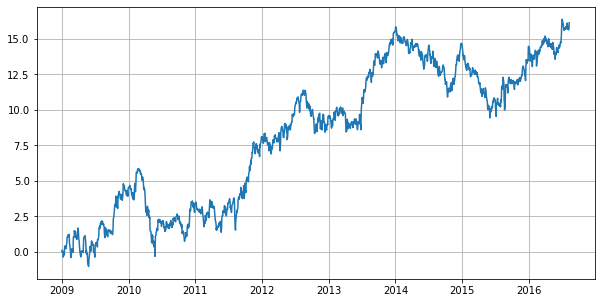

In [73]:
summary_pnl(portfolio_df_nc, turn_over_df_nc, price_s)

In [39]:
industry_fg

,A005930,A000660,A035420,A005380,A207940,A068270,A012330,A051910,A055550,A017670,...,A321260,A310840,A310870,A320000,A258790,A323210,A264290,A310200,A149940,A017680
2009-01-01,FGSC.45,FGSC.45,FGSC.45,FGSC.25,FGSC.35,FGSC.35,FGSC.25,FGSC.15,FGSC.40,FGSC.50,...,NaN,FGSC.40,FGSC.40,NaN,FGSC.40,NaN,FGSC.40,FGSC.40,FGSC.45,FGSC.25
2009-01-02,FGSC.45,FGSC.45,FGSC.45,FGSC.25,FGSC.35,FGSC.35,FGSC.25,FGSC.15,FGSC.40,FGSC.50,...,NaN,FGSC.40,FGSC.40,NaN,FGSC.40,NaN,FGSC.40,FGSC.40,FGSC.45,FGSC.25
2009-01-05,FGSC.45,FGSC.45,FGSC.45,FGSC.25,FGSC.35,FGSC.35,FGSC.25,FGSC.15,FGSC.40,FGSC.50,...,NaN,FGSC.40,FGSC.40,NaN,FGSC.40,NaN,FGSC.40,FGSC.40,FGSC.45,FGSC.25
2009-01-06,FGSC.45,FGSC.45,FGSC.45,FGSC.25,FGSC.35,FGSC.35,FGSC.25,FGSC.15,FGSC.40,FGSC.50,...,NaN,FGSC.40,FGSC.40,NaN,FGSC.40,NaN,FGSC.40,FGSC.40,FGSC.45,FGSC.25
2009-01-07,FGSC.45,FGSC.45,FGSC.45,FGSC.25,FGSC.35,FGSC.35,FGSC.25,FGSC.15,FGSC.40,FGSC.50,...,NaN,FGSC.40,FGSC.40,NaN,FGSC.40,NaN,FGSC.40,FGSC.40,FGSC.45,FGSC.25
2009-01-08,FGSC.45,FGSC.45,FGSC.45,FGSC.25,FGSC.35,FGSC.35,FGSC.25,FGSC.15,FGSC.40,FGSC.50,...,NaN,FGSC.40,FGSC.40,NaN,FGSC.40,NaN,FGSC.40,FGSC.40,FGSC.45,FGSC.25
2009-01-09,FGSC.45,FGSC.45,FGSC.45,FGSC.25,FGSC.35,FGSC.35,FGSC.25,FGSC.15,FGSC.40,FGSC.50,...,NaN,FGSC.40,FGSC.40,NaN,FGSC.40,NaN,FGSC.40,FGSC.40,FGSC.45,FGSC.25
2009-01-12,FGSC.45,FGSC.45,FGSC.45,FGSC.25,FGSC.35,FGSC.35,FGSC.25,FGSC.15,FGSC.40,FGSC.50,...,NaN,FGSC.40,FGSC.40,NaN,FGSC.40,NaN,FGSC.40,FGSC.40,FGSC.45,FGSC.25
2009-01-13,FGSC.45,FGSC.45,FGSC.45,FGSC.25,FGSC.35,FGSC.35,FGSC.25,FGSC.15,FGSC.40,FGSC.50,...,NaN,FGSC.40,FGSC.40,NaN,FGSC.40,NaN,FGSC.40,FGSC.40,FGSC.45,FGSC.25
2009-01-14,FGSC.45,FGSC.45,FGSC.45,FGSC.25,FGSC.35,FGSC.35,FGSC.25,FGSC.15,FGSC.40,FGSC.50,...,NaN,FGSC.40,FGSC.40,NaN,FGSC.40,NaN,FGSC.40,FGSC.40,FGSC.45,FGSC.25


In [31]:
signal = price_s.rolling(5, min_periods=1).mean()
portfolio_df_nc,turn_over_df_nc = mean_reversion_nc(signal)

,Sharp_ratio,Profit and Loss(%),Turn_over_rate(%)
2009-12-31,1.325773,4.409403,38.686288
2010-12-31,-0.311945,-1.053154,47.472726
2011-12-31,1.298668,4.713885,44.562491
2012-12-31,0.408385,1.458432,47.459666
2013-12-31,1.908230,6.030775,57.298699
2014-12-31,-0.272001,-0.841012,54.256255
2015-12-31,-0.056719,-0.198834,43.507732
2016-12-31,0.843091,2.786745,51.332606


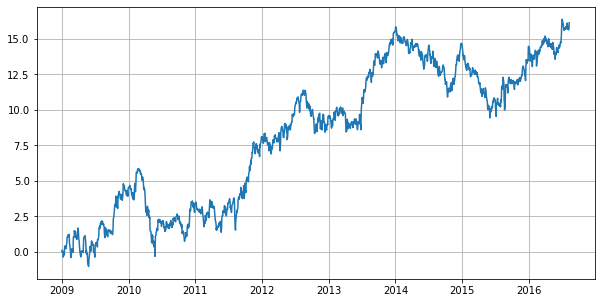

In [34]:
summary_pnl(portfolio_df_nc, turn_over_df_nc, price_s)

In [110]:
 np.sum(np.where(np.isnan(price_s.values), 0,1),1)

array([1711, 1711, 1711, ..., 1934, 1934, 1935])

In [112]:
daily_pnl

array([ 0.95080655,  2.01575102,  0.75621274, ..., -0.25710445,
       -0.00215615,  0.41806718])

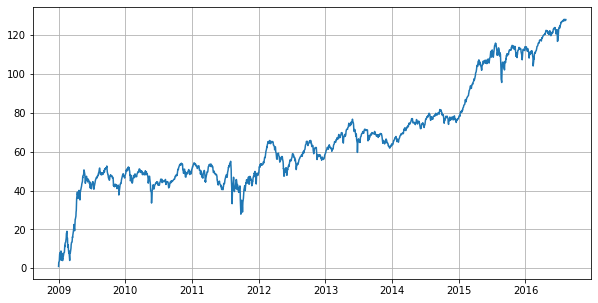

In [113]:
daily_pnl = (np.nansum(price_s.values, 1)/ np.sum(np.where(np.isnan(price_s.values), 0,1),1))
#draw_pnl(np.cumsum(daily_pnl), price_s.index)
cumsum_data = pd.Series(np.cumsum(daily_pnl))
cumsum_data.index = price_s.index
plt.figure(figsize=(10,5))
plt.plot(cumsum_data)
plt.grid(b = True)

draw_data = pd.Series(daily_pnl)
draw_data.index = price_s.index

summary_table = pd.DataFrame(index=draw_data.resample('Y').mean().index , columns=['Sharp_ratio', 'Profit and Loss(%)', 'Turn_over_rate(%)'])
summary_table['Sharp_ratio'] = draw_data.resample('Y').mean() *np.sqrt(250) / draw_data.resample('Y').std()
summary_table['Profit and Loss(%)'] = draw_data.resample('Y').mean() *250
#summary_table['Turn_over_rate(%)'] = turn_over_df.resample('Y').mean() *100

In [105]:
summary_table

,Sharp_ratio,Profit and Loss(%),Turn_over_rate(%)
2009-12-31,2.292953,46.624162,NaN
2010-12-31,0.213118,3.050636,NaN
2011-12-31,-0.081451,-1.999021,NaN
2012-12-31,0.709634,9.875684,NaN
2013-12-31,0.456283,5.854593,NaN
2014-12-31,1.377870,13.381813,NaN
2015-12-31,2.267332,37.229906,NaN
2016-12-31,1.587092,23.390269,NaN


In [81]:
hey = price_s.values

In [82]:
hey.shape

(1890, 3168)

In [ ]:
# mean_reversion 포트폴리오 생성 전략
def mean_reversion(input_data, industry_list, industry_dic) :
    #input_data = pr_rolling
    total_ammount = 1

    portfolio = np.zeros(input_data.shape)
    nn_price_s = input_data.values

    for industry in industry_list :
        print(industry)
        loading_m = industry_dic[industry]
        loading_return = np.where(loading_m == 1, nn_price_s, np.nan)
        #여기 0값 집어넣어서 난리남..

        for i in range(len(input_data.index)) :

            loading_return[i] -= np.nanmean(loading_return[i])
            loading_return[i] = np.where(np.isnan(loading_return[i]), 0, loading_return[i])

            portfolio[i] += loading_return[i] 


    portfolio = np.where(np.isnan(portfolio),0 , portfolio)
    portfolio = np.where(portfolio > 0 , -1, 1)

    abs_sum = np.sum(np.abs(portfolio), 1)
    weight = total_ammount/abs_sum 
    weight[total_ammount/abs_sum == np.inf] = 0
    d = np.diag(weight)
    portfolio_w = np.matmul(d, portfolio )


    #make portfolio df with init zero
    portfolio_df = input_data.copy()
    for col in portfolio_df.columns:
        portfolio_df[col].values[:] = 0

    portfolio_df.loc[:,:] = portfolio_w
    turn_over_df = make_turn_over_df(portfolio_w , input_data.index)
    
    
    portfolio_df = portfolio_df.shift(1)
    
    return portfolio_df,turn_over_df

In [94]:
# mean_reversion 포트폴리오 생성 전략
def mean_reversion2(input_data_arr, industry_list, industry_dic) :
    total_ammount = 1

    portfolio = np.zeros(input_data_arr.shape)
    nn_price_s = input_data_arr

    for industry in industry_list :
       #print(industry)
        loading_m = industry_dic[industry]
        loading_return = np.where(loading_m == 1, nn_price_s, np.nan)

        for i in range(len(input_data_arr)) :

            loading_return[i] -= np.nanmean(loading_return[i])
            loading_return[i] = np.where(np.isnan(loading_return[i]), 0, loading_return[i])

            portfolio[i] += loading_return[i] 


    portfolio = np.where(np.isnan(portfolio),0 , portfolio)
    portfolio = np.where(portfolio > 0 , -1, 1)

    abs_sum = np.sum(np.abs(portfolio), 1)
    weight = total_ammount/abs_sum 
    weight[total_ammount/abs_sum == np.inf] = 0
    d = np.diag(weight)
    portfolio_w = np.matmul(d, portfolio )
    daily_pnl = np.nansum(np.multiply( portfolio_w[:-1], price_s[1:]),1)
    coeff = np.sqrt(len(daily_pnl))
    return coeff*np.nanmean(daily_pnl)/np.nanstd(daily_pnl)

In [98]:
price_t.shape

(799, 3168)

In [97]:
price_s.shape

(1890, 3168)

In [95]:
 mean_reversion2(signal.values, industry_list, industry_dic)

C:\Users\cobook\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


5.022556604490509

In [ ]:
daily_pnl = np.nansum(np.multiply( portfolio_w[:-1], price_s[1:]),1)
np.nansum(daily_pnl)/np.nanstd(daily_pnl)

In [85]:
np.nanstd([1, 2, 3, 4])

1.118033988749895